# Phase 2 — Full Pipeline with Reranking

Independent pipeline that extracts its own memories, builds its own database and test cases,
then runs retrieval experiments with cross-encoder reranking.

Unlike `phase1_reranking_comparison.ipynb` (which reuses Phase 1 data), this notebook
owns its entire pipeline end-to-end, allowing independent prompt/extraction iteration.

In [15]:
# Cell 1 — Setup & Imports
import os
from pathlib import Path

from memory_retrieval.memories.extractor import extract_memories, ExtractionConfig, SituationFormat
from memory_retrieval.search.vector import VectorBackend
from memory_retrieval.search.reranker import Reranker
from memory_retrieval.experiments.runner import run_all_experiments, ExperimentConfig
from memory_retrieval.experiments.test_cases import build_test_cases
from memory_retrieval.memories.schema import FIELD_SITUATION, FIELD_DISTANCE, FIELD_RERANK_SCORE
from memory_retrieval.infra.io import load_json
from memory_retrieval.infra.runs import (
    create_run, get_latest_run, get_run, list_runs, update_run_status,
    PHASE2,
)

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# Verify API key
if not os.environ.get("OPENROUTER_API_KEY"):
    print("WARNING: OPENROUTER_API_KEY is not set. Memory building and experiments will fail.")
else:
    print("OPENROUTER_API_KEY is set.")

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

OPENROUTER_API_KEY is set.
Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [16]:
# Cell 2 — Configuration

PROMPT_VERSION = "2.0.0"
MODEL_MEMORIES = "anthropic/claude-haiku-4.5"    # LLM for memory extraction
MODEL_EXPERIMENT = "anthropic/claude-sonnet-4.5"  # LLM for query generation

RAW_DATA_DIR = "data/review_data"

# Reranking configuration
RERANK_TOP_N = 6          # Final results after reranking
SEARCH_LIMIT = 20         # Vector search candidates per query
DISTANCE_THRESHOLD = 1.1  # For pre-rerank metrics comparison

# Rerank text strategies: compare reranking on situation-only vs situation+lesson
RERANK_TEXT_STRATEGIES = {
    "situation_only": lambda c: c["situation"],
    "situation_and_lesson": lambda c: f"situation: {c['situation']}; lesson: {c.get('lesson', '')}",
}

# Run selection: use latest run or select a specific one
# To create a new run: RUN_DIR = None (will be created in Step 1)
# To see available runs: print(list_runs(PHASE2))
# To select specific run: RUN_DIR = get_run(PHASE2, "run_20260209_120000")
# RUN_DIR = get_latest_run(PHASE2)
RUN_DIR = None

# Derived paths (automatic from run directory)
if RUN_DIR is not None:
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")

# Initialize backends
vector_backend = VectorBackend()

print("Configuration:")
print(f"  Using run: {RUN_DIR.name if RUN_DIR else 'None (will create new)'}")
print(f"  Prompt version: {PROMPT_VERSION}")
print(f"  Model (memories): {MODEL_MEMORIES}")
print(f"  Model (experiment): {MODEL_EXPERIMENT}")
print(f"  Rerank top-n: {RERANK_TOP_N}")
print(f"  Search limit: {SEARCH_LIMIT}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD}")
print(f"  Rerank strategies: {list(RERANK_TEXT_STRATEGIES.keys())}")
print(f"  Raw data dir: {RAW_DATA_DIR}")

Configuration:
  Using run: None (will create new)
  Prompt version: 2.0.0
  Model (memories): anthropic/claude-haiku-4.5
  Model (experiment): anthropic/claude-sonnet-4.5
  Rerank top-n: 6
  Search limit: 20
  Distance threshold: 1.1
  Rerank strategies: ['situation_only', 'situation_and_lesson']
  Raw data dir: data/review_data


## Step 1 — Build Memories

Extracts structured memories from raw code review data via LLM.
Each memory contains a **situation description** (25-60 words) and an **actionable lesson** (max 160 chars).

Uses Phase 2 prompts from `data/prompts/phase2`.

Requires `OPENROUTER_API_KEY`.

In [17]:
# Cell 4 — Build Memories: Single File

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Found {len(raw_files)} raw data files:")
for i, f in enumerate(raw_files):
    print(f"  [{i}] {f.name}")

if raw_files:
    target_file = raw_files[0]
    print(f"\nProcessing: {target_file.name}")
    extraction_config = ExtractionConfig(
        situation_format=SituationFormat.SINGLE,
        prompts_dir="data/prompts/phase2",
        prompt_version=PROMPT_VERSION,
        model=MODEL_MEMORIES,
    )
    output_path = extract_memories(
        raw_path=str(target_file),
        out_dir=MEMORIES_DIR,
        config=extraction_config,
    )
    print(f"Output saved to: {output_path}")
else:
    print("No raw data files found.")

Created new run: run_20260211_132752
Found 11 raw data files:
  [0] review_1.json
  [1] review_10.json
  [2] review_11.json
  [3] review_2.json
  [4] review_3.json
  [5] review_4.json
  [6] review_5.json
  [7] review_6.json
  [8] review_7.json
  [9] review_8.json
  [10] review_9.json

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260211_132752/memories/memories_review_1_20260211_132752.jsonl
Rejected: 1 -> data/phase2/runs/run_20260211_132752/memories/rejected_review_1_20260211_132752.jsonl
Output saved to: data/phase2/runs/run_20260211_132752/memories/memories_review_1_20260211_132752.jsonl


In [18]:
# Cell 5 — Build Memories: All Files

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Processing all {len(raw_files)} raw data files...\n")

extraction_config = ExtractionConfig(
    situation_format=SituationFormat.SINGLE,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_MEMORIES,
)

results = []
for f in raw_files:
    print(f"Processing: {f.name}")
    try:
        output_path = extract_memories(
            raw_path=str(f),
            out_dir=MEMORIES_DIR,
            config=extraction_config,
        )
        results.append({"file": f.name, "output": output_path, "status": "ok"})
    except Exception as e:
        results.append({"file": f.name, "output": None, "status": str(e)})
        print(f"  ERROR: {e}")

success_count = sum(1 for r in results if r['status'] == 'ok')
print(f"\nSummary: {success_count}/{len(results)} files processed successfully.")

# Update run status
update_run_status(RUN_DIR, "build_memories", {
    "count": success_count,
    "failed": len(results) - success_count,
    "prompt_version": PROMPT_VERSION,
})

Processing all 11 raw data files...

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260211_132752/memories/memories_review_1_20260211_132804.jsonl
Rejected: 1 -> data/phase2/runs/run_20260211_132752/memories/rejected_review_1_20260211_132804.jsonl
Processing: review_10.json
Memories written: 5 -> data/phase2/runs/run_20260211_132752/memories/memories_review_10_20260211_132815.jsonl
Rejected: 0 -> data/phase2/runs/run_20260211_132752/memories/rejected_review_10_20260211_132815.jsonl
Processing: review_11.json
Memories written: 4 -> data/phase2/runs/run_20260211_132752/memories/memories_review_11_20260211_132832.jsonl
Rejected: 0 -> data/phase2/runs/run_20260211_132752/memories/rejected_review_11_20260211_132832.jsonl
Processing: review_2.json
Memories written: 2 -> data/phase2/runs/run_20260211_132752/memories/memories_review_2_20260211_132849.jsonl
Rejected: 3 -> data/phase2/runs/run_20260211_132752/memories/rejected_review_2_20260211_132849.jsonl
Processing: r

## Step 2 — Create Database

Builds a SQLite database with **sqlite-vec** for vector similarity search.
Loads all accepted memories from JSONL files and indexes their situation descriptions
as 1024-dimensional embeddings (via Ollama `mxbai-embed-large`).

Requires Ollama running locally with the `mxbai-embed-large` model.

In [19]:
# Cell 7 — Rebuild Database
print(f"Rebuilding database for run: {RUN_DIR.name}...")
vector_backend.rebuild_database(db_path=DB_PATH, memories_dir=MEMORIES_DIR)

count = vector_backend.get_memory_count(DB_PATH)
print(f"Database rebuilt. Total memories indexed: {count}")

# Update run status
update_run_status(RUN_DIR, "db", {"memory_count": count})

Rebuilding database for run: run_20260211_132752...
Creating database at data/phase2/runs/run_20260211_132752/memories/memories.db...
Loading memories from data/phase2/runs/run_20260211_132752/memories...
Found 44 memories
Inserting memories (generating embeddings via Ollama)...
  [1/44] Embedding mem_47f0c280ca8f...
  [2/44] Embedding mem_c2f2a5c775fa...
  [3/44] Embedding mem_f29050903e92...
  [4/44] Embedding mem_a837453d376b...
  [5/44] Embedding mem_b4ad4ce6e957...
  [6/44] Embedding mem_1612ebdc2c47...
  [7/44] Embedding mem_2d59c41a863a...
  [8/44] Embedding mem_096734322f1d...
  [9/44] Embedding mem_b09708770b0e...
  [10/44] Embedding mem_638ce08683ad...
  [11/44] Embedding mem_2820ddc0fe87...
  [12/44] Embedding mem_34266ff3703c...
  [13/44] Embedding mem_e8c9ad8a96c0...
  [14/44] Embedding mem_cafa9a1ffead...
  [15/44] Embedding mem_2f8ce93b1f40...
  [16/44] Embedding mem_0d04f837da04...
  [17/44] Embedding mem_5a7b6395866b...
  [18/44] Embedding mem_7847dca3ec16...
  [19/44]

In [20]:
# Cell 8 — Verify Database: Sample Search
sample_query = "error handling in async functions"
print(f'Sample search: "{sample_query}"\n')

results = vector_backend.search(db_path=DB_PATH, query=sample_query, limit=5)

if results:
    for i, r in enumerate(results):
        print(f"--- Result {i + 1} (distance: {r.raw_score:.4f}) ---")
        print(f"  ID: {r.id}")
        print(f"  Situation: {r.situation}")
        print(f"  Lesson: {r.lesson}")
        print()
else:
    print("No results found. Check that the database is populated and Ollama is running.")

Sample search: "error handling in async functions"

--- Result 1 (distance: 0.6833) ---
  ID: mem_79341527ecad
  Situation: Form submission handler catching async errors without clearing prior error state. Error message persists across retries; successful API call doesn't reset error before updating UI, leaving stale error visible after save completes.
  Lesson: Always clear error state at the start of async operations to prevent stale errors from persisting after successful retries.

--- Result 2 (distance: 0.8768) ---
  ID: mem_f741fa509ff2
  Situation: Exception filter catching specific exception type with optional chaining on context object. Accesses context.data property without verifying it matches expected structure; conditional checks existence but lacks type validation before passing to downstream mapping method.
  Lesson: Verify context.data matches the expected type before passing it to downstream methods, not just the exception type.

--- Result 3 (distance: 0.8794) ---
  I

## Step 3 — Create Test Cases

Matches raw PR data to extracted memories to build **ground truth** test cases.
Each test case contains the filtered diff, PR context, and the set of memory IDs that should be retrieved.
PRs with no matching memories are skipped.

In [21]:
# Cell 10 — Build Test Cases
print(f"Building test cases for run: {RUN_DIR.name}...\n")
build_test_cases(
    raw_dir=RAW_DATA_DIR,
    memories_dir=MEMORIES_DIR,
    output_dir=TEST_CASES_DIR,
)

test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))
print(f"\nGenerated {len(test_case_files)} test cases:")
for f in test_case_files:
    tc = load_json(str(f))
    gt_count = tc.get("ground_truth_count", len(tc.get("ground_truth_memory_ids", [])))
    print(f"  {f.name} — {gt_count} ground truth memories")

# Update run status
update_run_status(RUN_DIR, "test_cases", {"count": len(test_case_files)})

Building test cases for run: run_20260211_132752...

Loading all memories...
Loaded 44 memories
[1/11] Processing review_1.json...
  Created test case with 6 ground truth memories
[2/11] Processing review_10.json...
  Created test case with 5 ground truth memories
[3/11] Processing review_11.json...
  Created test case with 4 ground truth memories
[4/11] Processing review_2.json...
  Created test case with 2 ground truth memories
[5/11] Processing review_3.json...
  Created test case with 2 ground truth memories
[6/11] Processing review_4.json...
  Created test case with 3 ground truth memories
[7/11] Processing review_5.json...
  Created test case with 5 ground truth memories
[8/11] Processing review_6.json...
  Created test case with 4 ground truth memories
[9/11] Processing review_7.json...
  Created test case with 4 ground truth memories
[10/11] Processing review_8.json...
  Created test case with 5 ground truth memories
[11/11] Processing review_9.json...
  Created test case with 

## Step 4 — Run Experiments with Reranking

For each test case:
1. Generate search queries from PR context and diff via LLM
2. Vector search for each query (top-20 candidates)
3. Pool and deduplicate results across queries
4. Rerank candidates with cross-encoder (bge-reranker-v2-m3)
5. Take top-N results after reranking
6. Compute metrics before and after reranking

Requires `OPENROUTER_API_KEY` and Ollama with `mxbai-embed-large`.

In [22]:
# Cell 12 — Test Reranker on Sample Query
reranker = Reranker()

sample_query = "error handling in async functions"
print(f'Sample query: "{sample_query}"\n')

# Vector search
results = vector_backend.search(DB_PATH, sample_query, limit=SEARCH_LIMIT)
print(f"Vector search returned {len(results)} candidates\n")

# Convert SearchResult objects to dicts for reranker
candidates = [
    {
        "id": r.id,
        FIELD_SITUATION: r.situation,
        "lesson": r.lesson,
        FIELD_DISTANCE: r.raw_score,
    }
    for r in results
]

# Show top-5 by distance
print(f"--- Top {RERANK_TOP_N} by Vector Distance ---")
for i, c in enumerate(candidates[:RERANK_TOP_N], 1):
    print(f"  [{i}] dist={c[FIELD_DISTANCE]:.4f} | {c['id']} | {c[FIELD_SITUATION][:80]}...")

# Rerank
reranked = reranker.rerank(sample_query, candidates, top_n=RERANK_TOP_N)

print(f"\n--- Top {RERANK_TOP_N} after Reranking ---")
for i, r in enumerate(reranked, 1):
    print(f"  [{i}] rerank={r[FIELD_RERANK_SCORE]:.4f} | dist={r[FIELD_DISTANCE]:.4f} | {r['id']}")
    print(f"      {r[FIELD_SITUATION][:100]}")
    print()

Sample query: "error handling in async functions"

Vector search returned 20 candidates

--- Top 6 by Vector Distance ---
  [1] dist=0.6833 | mem_79341527ecad | Form submission handler catching async errors without clearing prior error state...
  [2] dist=0.8768 | mem_f741fa509ff2 | Exception filter catching specific exception type with optional chaining on cont...
  [3] dist=0.8794 | mem_47f0c280ca8f | Command-line tool function opening file with unwrap() on Result. Error handling ...
  [4] dist=0.8800 | mem_92d1e4757e8d | Service method executing async database insert within loop. Missing `await` on `...
  [5] dist=0.8903 | mem_5fdd9c578bd6 | useEffect hook fetching data without AbortController. Missing cleanup function t...
  [6] dist=0.8959 | mem_96970d77894e | Route handler performing password update followed by token revocation without aw...
Loading reranker model: BAAI/bge-reranker-v2-m3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Reranker model loaded in 4.4s

--- Top 6 after Reranking ---
  [1] rerank=0.8634 | dist=0.6833 | mem_79341527ecad
      Form submission handler catching async errors without clearing prior error state. Error message pers

  [2] rerank=0.1735 | dist=0.8794 | mem_47f0c280ca8f
      Command-line tool function opening file with unwrap() on Result. Error handling bypassed for file I/

  [3] rerank=0.0239 | dist=0.8959 | mem_96970d77894e
      Route handler performing password update followed by token revocation without awaiting. Async operat

  [4] rerank=0.0085 | dist=0.8800 | mem_92d1e4757e8d
      Service method executing async database insert within loop. Missing `await` on `db.execute()` call f

  [5] rerank=0.0040 | dist=0.9559 | mem_cc83c544db09
      Form component managing fetch state manually with useState for loading, error, and data. Duplicates 

  [6] rerank=0.0019 | dist=0.8768 | mem_f741fa509ff2
      Exception filter catching specific exception type with optional chaining on

In [23]:
# Cell 13 — Run All Experiments with Reranking
print(f"Running all experiments for run: {RUN_DIR.name}...\n")

config = ExperimentConfig(
    search_backend=vector_backend,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_EXPERIMENT,
    search_limit=SEARCH_LIMIT,
    distance_threshold=DISTANCE_THRESHOLD,
    reranker=reranker,
    rerank_top_n=RERANK_TOP_N,
    rerank_text_strategies=RERANK_TEXT_STRATEGIES,
)
all_results = run_all_experiments(
    test_cases_dir=TEST_CASES_DIR,
    db_path=DB_PATH,
    results_dir=RESULTS_DIR,
    config=config,
)

# Update run status
successful = [r for r in all_results if "post_rerank_metrics" in r]
avg_f1 = sum(r["post_rerank_metrics"]["f1"] for r in successful) / len(successful) if successful else 0
update_run_status(RUN_DIR, "experiment", {
    "count": len(successful),
    "failed": len(all_results) - len(successful),
    "avg_f1_post_rerank": round(avg_f1, 4),
    "rerank_top_n": RERANK_TOP_N,
    "rerank_strategies": list(RERANK_TEXT_STRATEGIES.keys()),
    "prompt_version": PROMPT_VERSION,
})

Running all experiments for run: run_20260211_132752...


[1/11] Processing review_1.json
Test case: tc_review_1
Ground truth memories: 6
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 8 queries
Strategy 'situation_only': pooled 35 candidates
Strategy 'situation_and_lesson': pooled 35 candidates

PRE-RERANK METRICS (threshold=1.1):
  Recall:    100.0%
  Precision: 17.1%
  F1 Score:  0.293

POST-RERANK [situation_only] (top-6):
  Recall:    100.0%
  Precision: 100.0%
  F1 Score:  1.000
  F1 DELTA:  +0.707 (improvement)

POST-RERANK [situation_and_lesson] (top-6):
  Recall:    100.0%
  Precision: 100.0%
  F1 Score:  1.000
  F1 DELTA:  +0.707 (improvement)

Results saved to: data/phase2/runs/run_20260211_132752/results/results_tc_review_1_exp_20260211_133140.json

[2/11] Processing review_10.json
Test case: tc_review_10
Ground truth memories: 5
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating querie

## Step 5 — Results Analysis

Fair comparison of distance-based vs rerank-based retrieval at the same N,
top-N sweep with distance baseline, score distribution analysis,
and **rerank score threshold sweep** (main deliverable).

In [24]:
# Cell A — Fair Top-N Comparison (same N for distance and rerank)
import numpy as np

# --- Helpers ---
def pool_and_deduplicate_by_distance(query_results):
    """Pool results from all queries and deduplicate by memory ID (keep best distance)."""
    best = {}
    for qr in query_results:
        for r in qr.get("results", []):
            mid = r["id"]
            dist = r.get("distance", float("inf"))
            if mid not in best or dist < best[mid].get("distance", float("inf")):
                best[mid] = r
    return sorted(best.values(), key=lambda x: x.get("distance", 0))


def get_reranked_results(data, strategy_name):
    """Get reranked_results for a strategy, handling single vs multi-strategy format."""
    if "rerank_strategies" in data and strategy_name in data["rerank_strategies"]:
        return data["rerank_strategies"][strategy_name]["reranked_results"]
    return data.get("reranked_results", [])


# --- Load results ---
from pathlib import Path
results_path = Path(RESULTS_DIR)
result_files = sorted(results_path.glob("*.json"))
all_data = [load_json(str(f)) for f in result_files]

successful = [d for d in all_data if "post_rerank_metrics" in d]
has_strategies = successful and "rerank_strategies" in successful[0]
strategy_names = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else ["default"]

N = RERANK_TOP_N

for strategy_name in strategy_names:
    print(f"\n{'='*100}")
    print(f"Fair Top-{N} Comparison: distance vs rerank — Strategy: {strategy_name}")
    print(f"{'='*100}")
    print(f"{'Test Case':<25} {'Dist F1':>8} {'Rank F1':>8} {'Delta':>8} {'Dist P':>7} {'Rank P':>7} {'Dist R':>7} {'Rank R':>7} {'GT':>4}")
    print("-" * 90)

    dist_f1s, rank_f1s = [], []

    for data in successful:
        tc_id = data.get("test_case_id", "?")[:25]
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        gt_count = len(gt_ids)

        # Distance baseline: pool + dedup + top-N by distance
        pooled_by_dist = pool_and_deduplicate_by_distance(data.get("queries", []))
        dist_top_n = pooled_by_dist[:N]
        dist_ids = {r["id"] for r in dist_top_n}
        d_hits = len(dist_ids & gt_ids)
        d_n = len(dist_ids)
        d_p = d_hits / d_n if d_n > 0 else 0.0
        d_r = d_hits / gt_count if gt_count > 0 else 0.0
        d_f1 = 2 * d_p * d_r / (d_p + d_r) if (d_p + d_r) > 0 else 0.0

        # Rerank: top-N by rerank score
        reranked = get_reranked_results(data, strategy_name)
        rank_top_n = reranked[:N]
        rank_ids = {r["id"] for r in rank_top_n}
        r_hits = len(rank_ids & gt_ids)
        r_n = len(rank_ids)
        r_p = r_hits / r_n if r_n > 0 else 0.0
        r_r = r_hits / gt_count if gt_count > 0 else 0.0
        r_f1 = 2 * r_p * r_r / (r_p + r_r) if (r_p + r_r) > 0 else 0.0

        delta = r_f1 - d_f1
        marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
        print(f"{tc_id:<25} {d_f1:>8.3f} {r_f1:>8.3f} {delta:>+7.3f}{marker} {d_p:>7.3f} {r_p:>7.3f} {d_r:>7.3f} {r_r:>7.3f} {gt_count:>4}")

        dist_f1s.append(d_f1)
        rank_f1s.append(r_f1)

    avg_d = np.mean(dist_f1s)
    avg_r = np.mean(rank_f1s)
    delta = avg_r - avg_d
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print("-" * 90)
    print(f"{'AVERAGE':<25} {avg_d:>8.3f} {avg_r:>8.3f} {delta:>+7.3f}{marker}")

    improved = sum(1 for d, r in zip(dist_f1s, rank_f1s) if r > d + 0.001)
    same = sum(1 for d, r in zip(dist_f1s, rank_f1s) if abs(r - d) <= 0.001)
    worse = sum(1 for d, r in zip(dist_f1s, rank_f1s) if r < d - 0.001)
    print(f"\nReranking helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}")

# Strategy comparison summary
if len(strategy_names) > 1:
    print(f"\n{'='*60}")
    print(f"STRATEGY COMPARISON (fair top-{N} avg F1)")
    print(f"{'='*60}")
    # Distance baseline (same for all strategies)
    dist_f1_all = []
    for data in successful:
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        pooled = pool_and_deduplicate_by_distance(data.get("queries", []))
        ids = {r["id"] for r in pooled[:N]}
        h = len(ids & gt_ids); n = len(ids); gc = len(gt_ids)
        p = h/n if n else 0; r = h/gc if gc else 0
        dist_f1_all.append(2*p*r/(p+r) if (p+r) else 0)
    print(f"  Distance top-{N}:        {np.mean(dist_f1_all):.3f}")
    for sname in strategy_names:
        sf1s = []
        for data in successful:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            rr = get_reranked_results(data, sname)[:N]
            ids = {r["id"] for r in rr}
            h = len(ids & gt_ids); n = len(ids); gc = len(gt_ids)
            p = h/n if n else 0; r = h/gc if gc else 0
            sf1s.append(2*p*r/(p+r) if (p+r) else 0)
        delta = np.mean(sf1s) - np.mean(dist_f1_all)
        print(f"  {sname:<22} {np.mean(sf1s):.3f} ({delta:+.3f} vs distance)")


Fair Top-6 Comparison: distance vs rerank — Strategy: situation_only
Test Case                  Dist F1  Rank F1    Delta  Dist P  Rank P  Dist R  Rank R   GT
------------------------------------------------------------------------------------------
tc_review_10                 0.909    0.909  +0.000=   0.833   0.833   1.000   1.000    5
tc_review_11                 0.800    0.800  +0.000=   0.667   0.667   1.000   1.000    4
tc_review_1                  1.000    1.000  +0.000=   1.000   1.000   1.000   1.000    6
tc_review_2                  0.250    0.250  +0.000=   0.167   0.167   0.500   0.500    2
tc_review_3                  0.250    0.250  +0.000=   0.167   0.167   0.500   0.500    2
tc_review_4                  0.444    0.444  +0.000=   0.333   0.333   0.667   0.667    3
tc_review_5                  0.182    0.545  +0.364+   0.167   0.500   0.200   0.600    5
tc_review_6                  0.800    0.800  +0.000=   0.667   0.667   1.000   1.000    4
tc_review_7                  

Top-N Sweep: Distance vs Rerank (averaged over 11 test cases)

   N  Dist F1  situation_only F1   Delta situation_and_le F1   Delta
--------------------------------------------------------------------
   1    0.308              0.368  +0.061              0.308  +0.000
   2    0.536              0.536  +0.000              0.516  -0.019
   3    0.665              0.651  -0.014              0.651  -0.014
   4    0.685              0.726  +0.040              0.675  -0.010
   5    0.683              0.719  +0.036              0.695  +0.012
   6    0.649              0.683  +0.033              0.660  +0.010
   8    0.562              0.590  +0.028              0.572  +0.010
  10    0.495              0.519  +0.024              0.519  +0.024
  15    0.377              0.385  +0.007              0.385  +0.007
  20    0.314              0.314  +0.000              0.314  +0.000


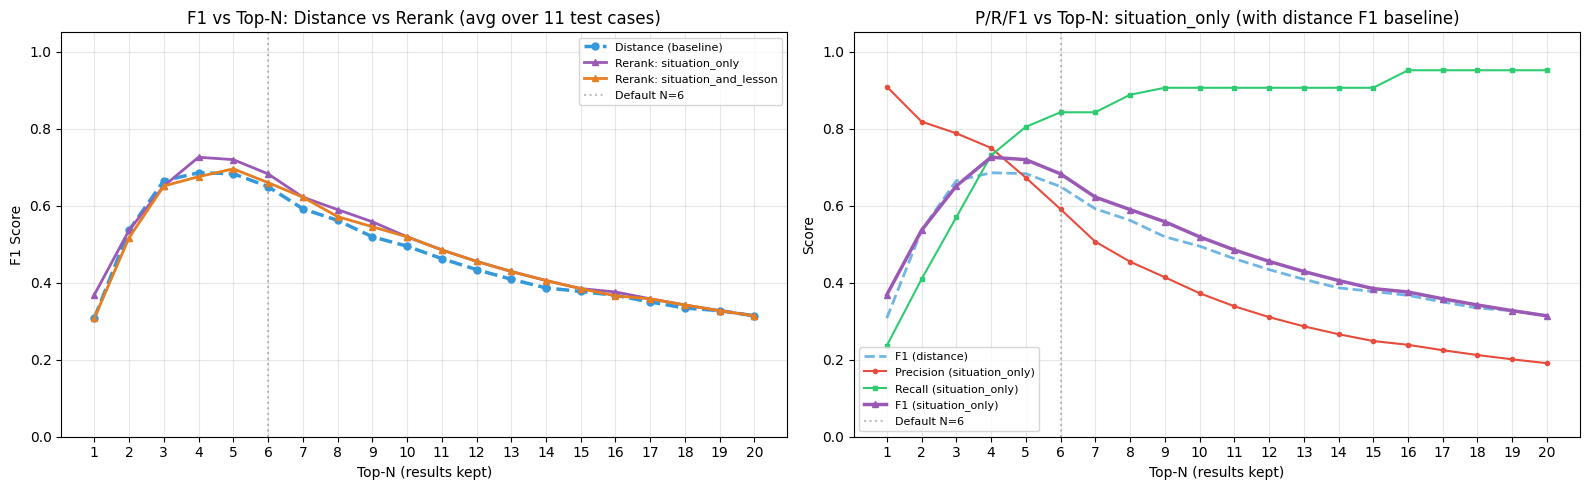

Saved: notebooks/phase2/figures/rerank_topn_sweep.png


In [25]:
# Cell B — Top-N Sweep: Distance Baseline vs Rerank Strategies
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = Path("notebooks/phase2/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

n_cases = len(successful)
max_n = 20
n_values = list(range(1, max_n + 1))

def compute_sweep(all_data, n_values, results_fn):
    """Compute P/R/F1 sweep for a given results accessor (returns list of dicts at each N)."""
    sweep_p, sweep_r, sweep_f1 = [], [], []
    for n in n_values:
        ps, rs, f1s = [], [], []
        for data in all_data:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            gt_count = len(gt_ids)
            results = results_fn(data)
            top_n_ids = {r["id"] for r in results[:n]}
            hits = len(top_n_ids & gt_ids)
            actual_n = len(top_n_ids)
            p = hits / actual_n if actual_n > 0 else 0.0
            r = hits / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            ps.append(p); rs.append(r); f1s.append(f1)
        sweep_p.append(np.mean(ps)); sweep_r.append(np.mean(rs)); sweep_f1.append(np.mean(f1s))
    return np.array(sweep_p), np.array(sweep_r), np.array(sweep_f1)

# Distance baseline sweep
dist_p, dist_r, dist_f1 = compute_sweep(
    successful, n_values,
    lambda data: pool_and_deduplicate_by_distance(data.get("queries", []))
)

# Per-strategy rerank sweeps
strategy_sweeps = {}
for key in strategy_names:
    strategy_sweeps[key] = compute_sweep(
        successful, n_values,
        lambda data, k=key: get_reranked_results(data, k)
    )

# Print table
print(f"Top-N Sweep: Distance vs Rerank (averaged over {n_cases} test cases)\n")
header = f"{'N':>4} {'Dist F1':>8}"
for key in strategy_names:
    header += f" {key[:16] + ' F1':>18} {'Delta':>7}"
print(header)
print("-" * (14 + 27 * len(strategy_names)))
for n in [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]:
    if n <= max_n:
        i = n - 1
        row = f"{n:>4} {dist_f1[i]:>8.3f}"
        for key in strategy_names:
            _, _, sf1 = strategy_sweeps[key]
            delta = sf1[i] - dist_f1[i]
            row += f" {sf1[i]:>18.3f} {delta:>+7.3f}"
        print(row)

# --- Plots ---
colors_rerank = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: F1 comparison — distance baseline + all strategies
ax = axes[0]
ax.plot(n_values, dist_f1, label="Distance (baseline)", color="#3498db", linewidth=2.5,
        marker="o", markersize=5, linestyle="--")
for i, key in enumerate(strategy_names):
    _, _, sf1 = strategy_sweeps[key]
    ax.plot(n_values, sf1, label=f"Rerank: {key}", color=colors_rerank[i % len(colors_rerank)],
            linewidth=2, marker="^", markersize=4)
ax.axvline(x=RERANK_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={RERANK_TOP_N}")
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("F1 Score")
ax.set_title(f"F1 vs Top-N: Distance vs Rerank (avg over {n_cases} test cases)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Right: P/R/F1 detail for best strategy + distance baseline
best_strategy = max(strategy_names, key=lambda k: strategy_sweeps[k][2][RERANK_TOP_N - 1])
bp, br, bf1 = strategy_sweeps[best_strategy]
ax = axes[1]
ax.plot(n_values, dist_f1, label="F1 (distance)", color="#3498db", linewidth=2, linestyle="--", alpha=0.7)
ax.plot(n_values, bp, label=f"Precision ({best_strategy})", color="#e74c3c", linewidth=1.5, marker="o", markersize=3)
ax.plot(n_values, br, label=f"Recall ({best_strategy})", color="#2ecc71", linewidth=1.5, marker="s", markersize=3)
ax.plot(n_values, bf1, label=f"F1 ({best_strategy})", color="#9b59b6", linewidth=2.5, marker="^", markersize=4)
ax.axvline(x=RERANK_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={RERANK_TOP_N}")
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1 vs Top-N: {best_strategy} (with distance F1 baseline)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_topn_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_topn_sweep.png'}")

[situation_only] GT rerank scores:     min=0.0001, max=0.9964, mean=0.6329, median=0.7662
[situation_only] Non-GT rerank scores: min=0.0001, max=0.6770, mean=0.0292, median=0.0042
[situation_only] Mean separation: 0.6037 (moderate)

[situation_and_lesson] GT rerank scores:     min=0.0001, max=0.9976, mean=0.7077, median=0.8606
[situation_and_lesson] Non-GT rerank scores: min=0.0002, max=0.9820, mean=0.0456, median=0.0068
[situation_and_lesson] Mean separation: 0.6621 (moderate)



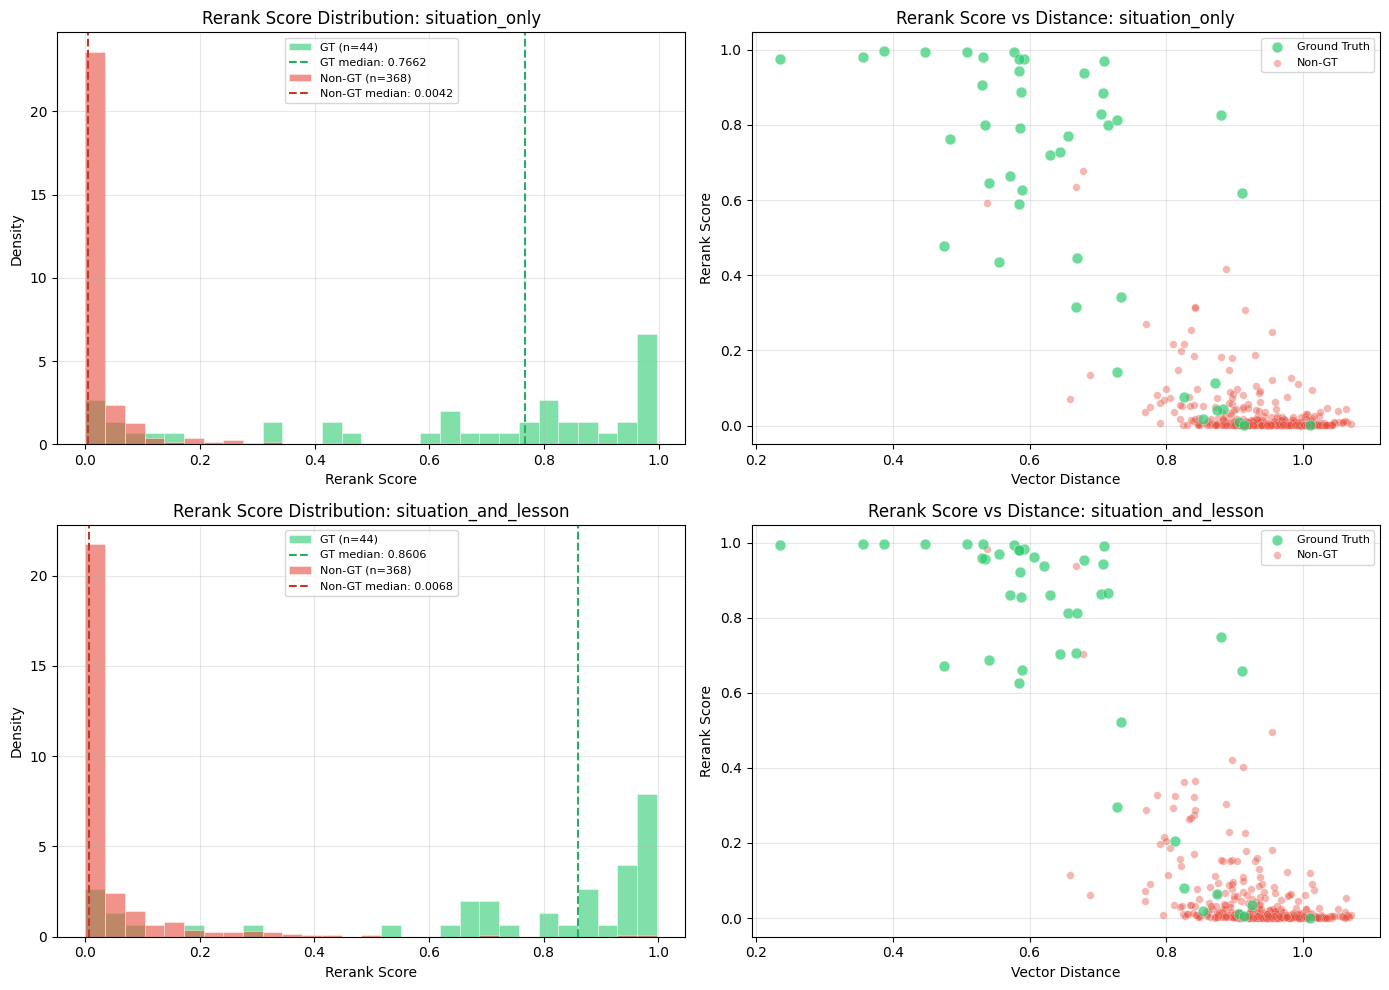

Saved: notebooks/phase2/figures/rerank_score_distribution.png


In [26]:
# Cell C — Rerank Score Distribution (Per Strategy)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

n_strategies = len(strategy_names)
fig, axes = plt.subplots(n_strategies, 2, figsize=(14, 5 * n_strategies), squeeze=False)

for row, key in enumerate(strategy_names):
    gt_scores, non_gt_scores = [], []
    gt_distances, non_gt_distances = [], []

    for data in successful:
        reranked = get_reranked_results(data, key)
        for r in reranked:
            if r.get("is_ground_truth"):
                gt_scores.append(r["rerank_score"])
                gt_distances.append(r["distance"])
            else:
                non_gt_scores.append(r["rerank_score"])
                non_gt_distances.append(r["distance"])

    gt_arr = np.array(gt_scores)
    non_gt_arr = np.array(non_gt_scores)

    # Left: Rerank score histogram (density-normalized)
    ax = axes[row][0]
    all_scores = np.concatenate([gt_arr, non_gt_arr])
    bins = np.linspace(all_scores.min(), all_scores.max(), 30)
    if len(gt_arr):
        ax.hist(gt_arr, bins=bins, alpha=0.6, density=True,
                label=f"GT (n={len(gt_arr)})", color="#2ecc71", edgecolor="white", linewidth=0.5)
        ax.axvline(np.median(gt_arr), color="#27ae60", linestyle="--", linewidth=1.5,
                   label=f"GT median: {np.median(gt_arr):.4f}")
    if len(non_gt_arr):
        ax.hist(non_gt_arr, bins=bins, alpha=0.6, density=True,
                label=f"Non-GT (n={len(non_gt_arr)})", color="#e74c3c", edgecolor="white", linewidth=0.5)
        ax.axvline(np.median(non_gt_arr), color="#c0392b", linestyle="--", linewidth=1.5,
                   label=f"Non-GT median: {np.median(non_gt_arr):.4f}")
    ax.set_xlabel("Rerank Score")
    ax.set_ylabel("Density")
    ax.set_title(f"Rerank Score Distribution: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Right: Rerank score vs distance scatter
    ax = axes[row][1]
    if gt_scores:
        ax.scatter(gt_distances, gt_scores, alpha=0.7, label="Ground Truth",
                   color="#2ecc71", s=60, zorder=3, edgecolors="white", linewidth=0.3)
    if non_gt_scores:
        ax.scatter(non_gt_distances, non_gt_scores, alpha=0.4, label="Non-GT",
                   color="#e74c3c", s=30, zorder=2, edgecolors="white", linewidth=0.3)
    ax.set_xlabel("Vector Distance")
    ax.set_ylabel("Rerank Score")
    ax.set_title(f"Rerank Score vs Distance: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Statistics
    if len(gt_arr):
        print(f"[{key}] GT rerank scores:     min={gt_arr.min():.4f}, max={gt_arr.max():.4f}, mean={gt_arr.mean():.4f}, median={np.median(gt_arr):.4f}")
    if len(non_gt_arr):
        print(f"[{key}] Non-GT rerank scores: min={non_gt_arr.min():.4f}, max={non_gt_arr.max():.4f}, mean={non_gt_arr.mean():.4f}, median={np.median(non_gt_arr):.4f}")
    if len(gt_arr) and len(non_gt_arr):
        separation = gt_arr.mean() - non_gt_arr.mean()
        print(f"[{key}] Mean separation: {separation:.4f} ({'good' if separation > 1.0 else 'moderate' if separation > 0.5 else 'weak'})")
    print()

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_score_distribution.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_score_distribution.png'}")

OPTIMAL THRESHOLDS PER STRATEGY
  situation_only:                threshold=0.3150  F1=0.747  P=0.823  R=0.738  MRR=0.909
  situation_and_lesson:          threshold=0.5000  F1=0.753  P=0.830  R=0.738  MRR=0.848

Best strategy: situation_and_lesson


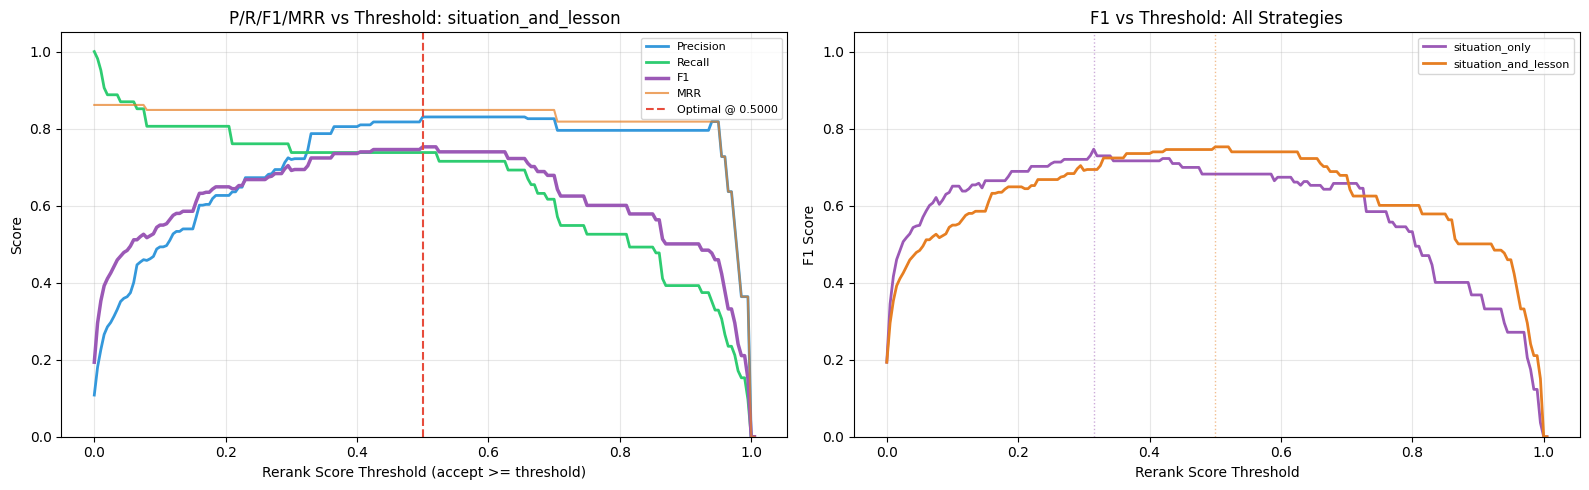

Saved: notebooks/phase2/figures/rerank_threshold_sweep.png

Threshold table: situation_and_lesson (macro-averaged over 11 test cases)
 Threshold  Precision   Recall       F1      MRR  Avg Accepted  Avg GT Kept
---------------------------------------------------------------------------
    0.0010      0.108    1.000    0.193    0.861          34.2          3.9
    0.0050      0.181    0.982    0.295    0.861          23.9          3.9
    0.0100      0.226    0.952    0.353    0.861          18.4          3.8
    0.0200      0.285    0.888    0.410    0.861          14.4          3.6
    0.0300      0.313    0.888    0.442    0.861          12.7          3.6
    0.0500      0.363    0.870    0.484    0.861          10.6          3.5
    0.0800      0.458    0.806    0.517    0.848           8.4          3.4
    0.1000      0.493    0.806    0.549    0.848           7.4          3.4
    0.1500      0.540    0.806    0.585    0.848           6.5          3.4
    0.2000      0.626    0.806

In [27]:
# Cell D — Rerank Score Threshold Sweep (MAIN DELIVERABLE)
import matplotlib.pyplot as plt
import numpy as np

# Build per-experiment reranked data for sweep
exp_reranked_by_strategy = {}
for key in strategy_names:
    exps = []
    for data in successful:
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        reranked = get_reranked_results(data, key)
        exps.append({
            "tc_id": data["test_case_id"],
            "gt_ids": gt_ids,
            "reranked": reranked,
        })
    exp_reranked_by_strategy[key] = exps

# Sweep thresholds per strategy
all_max_scores = []
for key in strategy_names:
    for er in exp_reranked_by_strategy[key]:
        if er["reranked"]:
            all_max_scores.append(max(r["rerank_score"] for r in er["reranked"]))
global_max = max(all_max_scores) if all_max_scores else 1.0
sweep_thresholds = np.arange(0.0, global_max + 0.01, 0.005)

strategy_sweep_results = {}
for key in strategy_names:
    sweep_p, sweep_r, sweep_f1, sweep_mrr = [], [], [], []
    for t in sweep_thresholds:
        ps, rs, f1s, rrs = [], [], [], []
        for er in exp_reranked_by_strategy[key]:
            accepted = {r["id"] for r in er["reranked"] if r["rerank_score"] >= t}
            gt_hit = len(accepted & er["gt_ids"])
            n_acc = len(accepted)
            gt_count = len(er["gt_ids"])
            p = gt_hit / n_acc if n_acc > 0 else 0.0
            r = gt_hit / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            ps.append(p); rs.append(r); f1s.append(f1)
            # MRR
            accepted_sorted = [r for r in er["reranked"] if r["rerank_score"] >= t]
            rr = 0.0
            for rank, res in enumerate(accepted_sorted, 1):
                if res["id"] in er["gt_ids"]:
                    rr = 1.0 / rank
                    break
            rrs.append(rr)
        sweep_p.append(np.mean(ps)); sweep_r.append(np.mean(rs))
        sweep_f1.append(np.mean(f1s)); sweep_mrr.append(np.mean(rrs))

    sweep_p = np.array(sweep_p); sweep_r = np.array(sweep_r)
    sweep_f1 = np.array(sweep_f1); sweep_mrr = np.array(sweep_mrr)
    best_idx = np.argmax(sweep_f1)
    strategy_sweep_results[key] = {
        "p": sweep_p, "r": sweep_r, "f1": sweep_f1, "mrr": sweep_mrr,
        "best_idx": best_idx, "best_threshold": sweep_thresholds[best_idx],
    }

# --- Print optimal thresholds ---
print("OPTIMAL THRESHOLDS PER STRATEGY")
best_overall_strategy = None
best_overall_f1 = -1
for key in strategy_names:
    sr = strategy_sweep_results[key]
    bi = sr["best_idx"]
    print(f"  {key + ':':30} threshold={sr['best_threshold']:.4f}  F1={sr['f1'][bi]:.3f}  P={sr['p'][bi]:.3f}  R={sr['r'][bi]:.3f}  MRR={sr['mrr'][bi]:.3f}")
    if sr["f1"][bi] > best_overall_f1:
        best_overall_f1 = sr["f1"][bi]
        best_overall_strategy = key

print(f"\nBest strategy: {best_overall_strategy}")

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: P/R/F1/MRR vs threshold for best strategy
sr = strategy_sweep_results[best_overall_strategy]
ax = axes[0]
ax.plot(sweep_thresholds, sr["p"], label="Precision", color="#3498db", linewidth=2)
ax.plot(sweep_thresholds, sr["r"], label="Recall", color="#2ecc71", linewidth=2)
ax.plot(sweep_thresholds, sr["f1"], label="F1", color="#9b59b6", linewidth=2.5)
ax.plot(sweep_thresholds, sr["mrr"], label="MRR", color="#e67e22", linewidth=1.5, alpha=0.7)
ax.axvline(sr["best_threshold"], color="#e74c3c", linestyle="--", linewidth=1.5,
           label=f"Optimal @ {sr['best_threshold']:.4f}")
ax.set_xlabel("Rerank Score Threshold (accept >= threshold)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1/MRR vs Threshold: {best_overall_strategy}")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# Right: F1 vs threshold for ALL strategies
ax = axes[1]
colors_strat = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
for i, key in enumerate(strategy_names):
    sr_i = strategy_sweep_results[key]
    ax.plot(sweep_thresholds, sr_i["f1"], label=key, color=colors_strat[i % len(colors_strat)], linewidth=2)
    ax.axvline(sr_i["best_threshold"], color=colors_strat[i % len(colors_strat)],
               linestyle=":", alpha=0.5, linewidth=1)
ax.set_xlabel("Rerank Score Threshold")
ax.set_ylabel("F1 Score")
ax.set_title("F1 vs Threshold: All Strategies")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_threshold_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_threshold_sweep.png'}")

# --- Threshold table for best strategy ---
sr = strategy_sweep_results[best_overall_strategy]
bt = sr["best_threshold"]
print(f"\nThreshold table: {best_overall_strategy} (macro-averaged over {len(successful)} test cases)")
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Avg Accepted':>13} {'Avg GT Kept':>12}")
print("-" * 75)

table_thresholds = sorted(set([
    0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.10, 0.15, 0.20, 0.30, 0.50,
    round(bt, 4),
]))
exps = exp_reranked_by_strategy[best_overall_strategy]
for t in table_thresholds:
    if t > global_max + 0.01:
        continue
    idx = np.argmin(np.abs(sweep_thresholds - t))
    avg_accepted = np.mean([len([r for r in er["reranked"] if r["rerank_score"] >= t]) for er in exps])
    avg_gt_kept = np.mean([len({r["id"] for r in er["reranked"] if r["rerank_score"] >= t} & er["gt_ids"]) for er in exps])
    marker = " <-- optimal" if abs(t - bt) < 0.003 else ""
    print(f"{t:>10.4f} {sr['p'][idx]:>10.3f} {sr['r'][idx]:>8.3f} {sr['f1'][idx]:>8.3f} {sr['mrr'][idx]:>8.3f} {avg_accepted:>13.1f} {avg_gt_kept:>12.1f}{marker}")

In [28]:
# Cell E — Per-Test-Case Impact at Optimal Threshold
import numpy as np

N = RERANK_TOP_N
key = best_overall_strategy
bt = strategy_sweep_results[key]["best_threshold"]
exps = exp_reranked_by_strategy[key]

print(f"Per-test-case comparison at best strategy's optimal threshold")
print(f"  Strategy: {key}")
print(f"  Threshold: score >= {bt:.4f}")
print(f"  Distance baseline: top-{N} by distance")
print()

print(f"{'Test Case':<20} {'Dist F1':>8} {'Thr F1':>8} {'Delta':>8} {'Dist P':>7} {'Thr P':>7} {'Dist R':>7} {'Thr R':>7} {'D Acc':>6} {'T Acc':>6} {'GT':>4}")
print("-" * 105)

dist_f1s, thr_f1s = [], []

for data, er in zip(successful, exps):
    tc_id = data["test_case_id"]
    gt_ids = er["gt_ids"]
    gt_count = len(gt_ids)

    # Distance baseline: top-N
    pooled = pool_and_deduplicate_by_distance(data.get("queries", []))
    dist_top = pooled[:N]
    dist_ids = {r["id"] for r in dist_top}
    d_h = len(dist_ids & gt_ids); d_n = len(dist_ids)
    d_p = d_h / d_n if d_n else 0; d_r = d_h / gt_count if gt_count else 0
    d_f1 = 2 * d_p * d_r / (d_p + d_r) if (d_p + d_r) else 0

    # Threshold-based
    thr_results = [r for r in er["reranked"] if r["rerank_score"] >= bt]
    thr_ids = {r["id"] for r in thr_results}
    t_h = len(thr_ids & gt_ids); t_n = len(thr_ids)
    t_p = t_h / t_n if t_n else 0; t_r = t_h / gt_count if gt_count else 0
    t_f1 = 2 * t_p * t_r / (t_p + t_r) if (t_p + t_r) else 0

    delta = t_f1 - d_f1
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print(f"{tc_id:<20} {d_f1:>8.3f} {t_f1:>8.3f} {delta:>+7.3f}{marker} {d_p:>7.1%} {t_p:>7.1%} {d_r:>7.1%} {t_r:>7.1%} {d_n:>6} {t_n:>6} {gt_count:>4}")

    # Show missed GT with their rerank scores
    missed = gt_ids - thr_ids
    if missed:
        for mid in sorted(missed):
            score = next((r["rerank_score"] for r in er["reranked"] if r["id"] == mid), None)
            if score is not None:
                print(f"  {'':20} Missed: {mid}  score={score:.4f} (below threshold {bt:.4f})")
            else:
                print(f"  {'':20} Missed: {mid}  NOT IN CANDIDATE POOL (query miss)")

    dist_f1s.append(d_f1)
    thr_f1s.append(t_f1)

avg_d = np.mean(dist_f1s)
avg_t = np.mean(thr_f1s)
delta = avg_t - avg_d
print("-" * 105)
print(f"{'AVERAGE':<20} {avg_d:>8.3f} {avg_t:>8.3f} {delta:>+7.3f}{'+'if delta>0.001 else '-' if delta<-0.001 else '='}")

improved = sum(1 for d, t in zip(dist_f1s, thr_f1s) if t > d + 0.001)
same = sum(1 for d, t in zip(dist_f1s, thr_f1s) if abs(t - d) <= 0.001)
worse = sum(1 for d, t in zip(dist_f1s, thr_f1s) if t < d - 0.001)
print(f"\nThreshold helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}")

Per-test-case comparison at best strategy's optimal threshold
  Strategy: situation_and_lesson
  Threshold: score >= 0.5000
  Distance baseline: top-6 by distance

Test Case             Dist F1   Thr F1    Delta  Dist P   Thr P  Dist R   Thr R  D Acc  T Acc   GT
---------------------------------------------------------------------------------------------------------
tc_review_10            0.909    1.000  +0.091+   83.3%  100.0%  100.0%  100.0%      6      5    5
tc_review_11            0.800    1.000  +0.200+   66.7%  100.0%  100.0%  100.0%      6      4    4
tc_review_1             1.000    1.000  +0.000=  100.0%  100.0%  100.0%  100.0%      6      6    6
tc_review_2             0.250    0.000  -0.250-   16.7%    0.0%   50.0%    0.0%      6      0    2
                       Missed: mem_0d04f837da04  score=0.0788 (below threshold 0.5000)
                       Missed: mem_5a7b6395866b  score=0.0112 (below threshold 0.5000)
tc_review_3             0.250    0.400  +0.150+   16.7%   33.